### Numerical features performed much better than categorical ones (alone)
### Combining both produced almost the same as just numerical, or slightly better
### Need a way to cluster head of household category 

### TODO FEATURE ENGINEERING

### Adding income levels based on regions (sonia) average income level for each region in the training set
### for each household, add # of sd's they are away from the average income level in their region

### Groupings for grade: none, elementary, high school, bachelors, masters, program/trade school (sonia)

### Percentage of family employed (# employed / total family) + interaction between the two terms (sonia)

### (hans) the rest

### Total number of electronics
### Total number of motorized vehicles
### housing/water expenditure x toilet facility interaction
### Clustering types of jobs

In [11]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

import re, math
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.cluster import SpectralClustering

In [82]:
def cosine_sim(u,v):
    res = np.array(np.dot(u, v.T) / (np.sqrt(np.dot(u,u.T)) * np.sqrt(np.dot(v,v.T)))).item(0,0)
    
    if not np.isnan(res):
        return res
    
    else:
        return 1e-5

In [83]:
def clean_jobs(df):
    jobs = np.unique(list(df['Household Head Occupation']))
    
    newJobs = np.array([])
    for job in jobs:
        temp = job.split(' ')
        temp = [word.lower() for word in temp if word.lower() not in stopwords.words('english')]
        newJobs = np.append(newJobs," ".join(temp))
        
    return newJobs

In [84]:
def stem_jobs(df):
    ps = PorterStemmer()
    newJobs = clean_jobs(df['Household Head Occupation'])
    stemmed_jobs = np.array([])
    
    for job in newJobs:
        temp = job.split(' ')
        temp = [ps.stem(word) for word in temp]
        stemmed_jobs = np.append(stemmed_jobs," ".join(temp))
        
    return stemmed_jobs

In [85]:
def cluster_jobs(df):
    stemmed_jobs = stem_jobs(df)
    numJobs = len(np.unique(df['Household Head Occupation']))
    
    # convert jobs to tf-idf vectors
    tfidf_vectorizer=TfidfVectorizer()
    tfidf_matrix=tfidf_vectorizer.fit_transform(stemmed_jobs)
    
    # get cosine similiarity between each job
    cos_sims = np.array([])
    for i in range(np.size(stemmed_jobs)):
        for j in range(np.size(stemmed_jobs)):
            cos_sims = np.append(cos_sims, cosine_sim(tfidf_matrix[i],tfidf_matrix[j]))
            
    cos_sims = np.reshape(cos_sims, (numJobs, numJobs))
    
    # cluster jobs into groupings
    mat = np.matrix(cos_sims)
    groups = SpectralClustering(15).fit_predict(mat)

    # add column of job category
    jobIndexes = np.concatenate([np.where(jobs == job)[0] for job in df['Household Head Occupation']])
    jobCategory = np.array([groups[num] for num in jobIndexes])
    
    print ('Length of job index {0}, job category {1}'.format(jobIndex.shape, jobCategory.shape))
    
    return jobCategory

In [62]:
def select_features_from_lasso(X, y, alpha):
    # fit lasso model and pass to select from model
    Xtrain =normalize(X)
    lasso = Lasso(alpha).fit(Xtrain, y)
    model = SelectFromModel(lasso, prefit=True)

    # new features
    X_new = model.transform(X)
    return X.columns[model.get_support()]

In [63]:
def backward_stepwise(X, y):
    model = LinearRegression()

    vars_remaining = []
    vars_in_model = list(X.columns)
    
    last_error = cross_val_score(model, X[vars_in_model], y, cv=10, scoring="neg_mean_squared_error").mean()
    
    for _ in range(len(vars_in_model)):
        scores = []
        for var in vars_in_model:
            candidate_vars = copy.copy(vars_in_model)
            candidate_vars.remove(var)
            Xtrain = X[candidate_vars]
            scores.append(
                cross_val_score(model, normalize(Xtrain), y, cv=10, scoring="neg_mean_squared_error").mean()
            )
        i = np.argmax(scores)
        if scores[i] <= last_error:
            break
        else:
            last_error = scores[i]
            del vars_in_model[i]
            
    return vars_in_model

In [64]:
def forward_stepwise(X, y):
    model = LinearRegression()

    vars_remaining = list(X.columns)
    vars_in_model = []
    last_error = -np.inf

    for _ in range(len(vars_remaining)):
        scores = []
        for var in vars_remaining:
            candidate_vars = vars_in_model + [var]
            Xtrain = X[candidate_vars]
            scores.append(
                cross_val_score(model, normalize(Xtrain), y, cv=10, scoring="neg_mean_squared_error").mean()
            )
        i = np.argmax(scores)
        if scores[i] <= last_error:
            break
        else:
            last_error = scores[i]
            var_to_add = vars_remaining[i]
            vars_in_model.append(var_to_add)
            del vars_remaining[i]

    return vars_in_model

In [65]:
def get_categorical_numeric(df):
    numerics = []
    categorical = []

    for col in df:
        if((df[col].dtype == np.float64 or df[col].dtype == np.int64) and col != 'Unnamed: 0'):
            numerics.append(col)

        else:
            categorical.append(col)

    categorical_df = df[categorical]
    numeric_df = df[numerics]
    
    return categorical_df, numeric_df

In [66]:
def remove_categorical(X, feat, columns):
    for col in columns:
        if col in X:
            keep = []

            for f in feat:
                if col + '_' in f:
                    keep.append(f.replace(col + '_', ''))

            X[col][~(X[col].isin(keep))] = 'other'

In [67]:
def get_income_zscores(df):
    regions = pd.DataFrame(df[['Total Household Income', 'Region']]
        .groupby('Region').agg([np.mean, np.std]).to_records())
    regions.columns = ['Region', 'Average Household Income', 'Standard Deviation']

    z_scores = []

    for income, region in zip(df['Total Household Income'], df['Region']):
        idx = list(regions['Region']).index(region)
        avg = list(regions['Average Household Income'])[idx]
        sd = list(regions['Standard Deviation'])[idx]

        z_scores.append((income - avg) / sd)

    return z_scores

In [68]:
def group_highest_grade(df):
    grades = []
    
    for grade in df['Household Head Highest Grade Completed']:
        grade = grade.lower().strip()

        if 'programs' in grade:
            grades.append('Program/Trade School')

        elif 'preschool' in grade:
            grades.append('Preschool')

        elif 'grade' in grade or 'elementary' in grade:
            grades.append('Elementary')

        elif 'high school' in grade:
            grades.append('High School')

        elif 'college' in grade:
            grades.append('College')

        elif 'secondary' in grade:
            grades.append('Post Secondary')

        elif 'baccalaureate' in grade:
            grades.append('Baccalaureate')
            
    return grades

In [69]:
def percentage_employed(df):
    df['Percentage of Family Employed'] = df['Total number of family members employed'] / df['Total Number of Family members']
    df['Interaction between family members and employed'] = df['Total number of family members employed'] * df['Total Number of Family members']

In [70]:
""" 
 use lasso regression to select columns for the model
 try a range of alpha parameters on the lasso model
 mode can be just categorical, numerical, or both
"""
def train_lasso(alphas, mode, df):
    mse = []
    y = df[['Total Household Income']] / 1e4
    df = df.drop(['Total Household Income', 'Unnamed: 0'], axis=1)
    
    for alpha in alphas:
        categorical_df, numeric_df = get_categorical_numeric(df)
        reg = LinearRegression()
        
        # only used categorical features
        # values not selected by lasso will be set to other
        if mode == "categorical":
            tmp = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            new_feat = select_features_from_lasso(tmp, y, alpha)
            remove_categorical(categorical_df, new_feat, categorical_df.columns)
            categorical_df = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(new_feat)))
            print
            print (', '.join(new_feat))
            print 
            scores = cross_val_score(reg, categorical_df, y, cv=5, scoring='neg_mean_squared_error')
           
        # only use numerical features, and normalize the data
        elif mode == "numerical":
            new_feat = select_features_from_lasso(numeric_df, y, alpha)
            Xnum = preprocessing.scale(numeric_df[new_feat])
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(new_feat)))
            print 
            print (', '.join(new_feat))
            print
            
            scores = cross_val_score(reg, Xnum, y, cv=5, scoring='neg_mean_squared_error')
        
        # use both features
        else:
            new_feat_cat = select_features_from_lasso(pd.get_dummies(categorical_df, categorical_df.columns), 
                y, alpha)
            remove_categorical(categorical_df, new_feat_cat, categorical_df.columns)
            categorical_df = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            
            new_feat_num = select_features_from_lasso(numeric_df, y, alpha)
            standardized = preprocessing.scale(numeric_df[new_feat_num])
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(categorical_df.columns) + 
                standardized.shape[1]))
            print
            print (', '.join(sorted(new_feat_num + new_feat_cat)))
            print
            
            total = np.concatenate((standardized, categorical_df.as_matrix()), axis=1)
            scores = cross_val_score(reg, total, y, cv=5, scoring='neg_mean_squared_error')

        print ("Alpha: {0}, MSE {1}".format(alpha, np.mean(scores)))
        print 

        mse.append(np.mean(scores))
        
    return mse

In [71]:
df = pd.read_csv('train.csv').dropna()

### Predict household income from just numerical features

### Lasso  regression to select numerical features
### Normalize features first? (Increased MSE ...)
### Alpha = 1e-5 selected 28 columns and produced the best MSE

In [10]:
mse = train_lasso([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1], "numerical", df)

Using alpha of 1e-06 39 columns were selected

Total Food Expenditure, Agricultural Household indicator, Bread and Cereals Expenditure, Total Rice Expenditure, Meat Expenditure, Total Fish and  marine products Expenditure, Fruit Expenditure, Vegetables Expenditure, Restaurant and hotels Expenditure, Alcoholic Beverages Expenditure, Tobacco Expenditure, Clothing, Footwear and Other Wear Expenditure, Housing and water Expenditure, Imputed House Rental Value, Medical Care Expenditure, Transportation Expenditure, Communication Expenditure, Education Expenditure, Miscellaneous Goods and Services Expenditure, Special Occasions Expenditure, Crop Farming and Gardening expenses, Total Income from Entrepreneurial Acitivites, Household Head Age, Total Number of Family members, Members with age 5 - 17 years old, Total number of family members employed, House Floor Area, House Age, Number of bedrooms, Electricity, Number of Television, Number of CD/VCD/DVD, Number of Refrigerator/Freezer, Number of

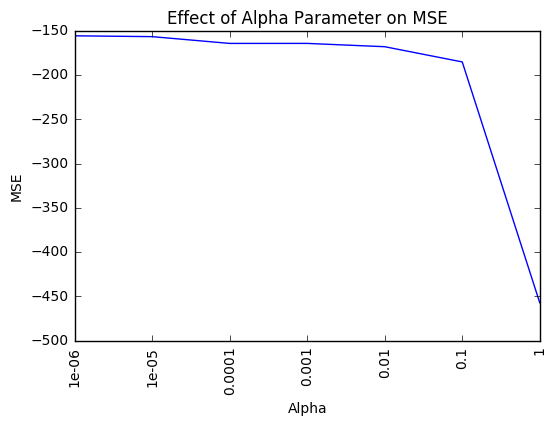

In [11]:
plt.plot(mse)
plt.xlabel('Alpha')
labels = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.ylabel('MSE')
plt.title('Effect of Alpha Parameter on MSE')
plt.show()

### Predict household income from just categorical features

### 500 columns after one-hot encoding and including all variables
### Household head occupation has 370 unique values (can probably be reduced)

### Alpha = 0.001 produced the best MSE and selected 107 columns
### For categorical variables, if the variable is chosen by lasso keep it, otherwise
### set it to an "other". Use the new dataframe in a linear regression model to
### get the mse

In [12]:
mse = train_lasso([1e-3, 1e-2, 0.1, 1],'categorical',df)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using alpha of 0.001 233 columns were selected

Region_ ARMM, Region_CAR, Region_Caraga, Region_I - Ilocos Region, Region_II - Cagayan Valley, Region_III - Central Luzon, Region_IVA - CALABARZON, Region_IVB - MIMAROPA, Region_IX - Zasmboanga Peninsula, Region_NCR, Region_V - Bicol Region, Region_VI - Western Visayas, Region_VIII - Eastern Visayas, Region_X - Northern Mindanao, Region_XI - Davao Region, Region_XII - SOCCSKSARGEN, Main Source of Income_Other sources of Income, Main Source of Income_Wage/Salaries, Household Head Sex_Female, Household Head Marital Status_Married, Household Head Marital Status_Single, Household Head Marital Status_Widowed, Household Head Highest Grade Completed_Agriculture, Forestry, and Fishery Programs, Household Head Highest Grade Completed_Architecture and Building Programs, Household Head Highest Grade Completed_Arts Programs, Household Head Highest Grade Completed_Business and Administration Programs, Household Head Highest Grade Completed_Elementary 

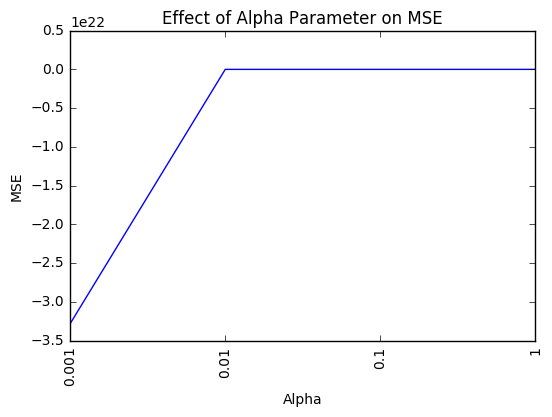

In [13]:
plt.plot(mse)
plt.xlabel('Alpha')
labels = [1e-3, 1e-2, 0.1, 1]
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.ylabel('MSE')
plt.title('Effect of Alpha Parameter on MSE')
plt.show()

### Use all the features to compute the MSE

In [14]:
mse = train_lasso([1e-2, 0.1, 0.5, 1], 'both', df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using alpha of 0.01 112 columns were selected

Bread and Cereals Expenditure, Clothing, Footwear and Other Wear Expenditure, Communication Expenditure, Crop Farming and Gardening expenses, Education Expenditure, Household Head Class of Worker_Employer in own family-operated farm or business, Household Head Class of Worker_Self-employed wihout any employee, Household Head Class of Worker_Worked for government/government corporation, Household Head Class of Worker_Worked for private establishment, Household Head Class of Worker_Worked for private household, Household Head Highest Grade Completed_Agriculture, Forestry, and Fishery Programs, Household Head Highest Grade Completed_Business and Administration Programs, Household Head Highest Grade Completed_Elementary Graduate, Household Head Highest Grade Completed_Engineering and Engineering Trades Programs, Household Head Highest Grade Completed_Engineering and Engineering trades Programs, Household Head Highest Grade Completed_First Year

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()


Alpha: 0.01, MSE -154.480486003

Using alpha of 0.1 44 columns were selected

Bread and Cereals Expenditure, Communication Expenditure, Crop Farming and Gardening expenses, Education Expenditure, Household Head Class of Worker_Employer in own family-operated farm or business, Household Head Class of Worker_Self-employed wihout any employee, Household Head Class of Worker_Worked for government/government corporation, Household Head Highest Grade Completed_Business and Administration Programs, Household Head Highest Grade Completed_Elementary Graduate, Household Head Highest Grade Completed_Engineering and Engineering Trades Programs, Household Head Highest Grade Completed_High School Graduate, Household Head Marital Status_Married, Household Head Occupation_Farmhands and laborers, Household Head Occupation_General managers/managing proprietors in wholesale and retail trade, Main Source of Water Supply_Own use, faucet, community water system, Main Source of Water Supply_Own use, tubed/pi

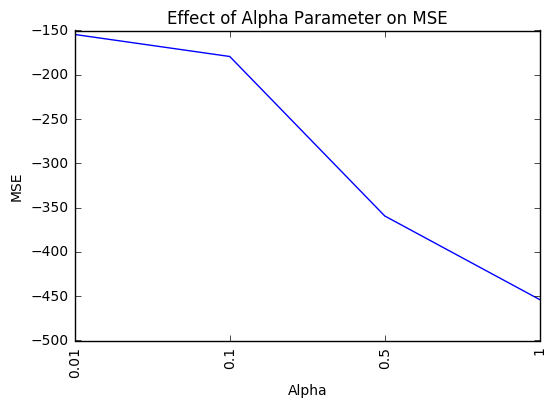

In [15]:
plt.plot(mse)
plt.xlabel('Alpha')
labels = [1e-2, 0.1, 0.5, 1]
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.ylabel('MSE')
plt.title('Effect of Alpha Parameter on MSE')
plt.show()

### Engineer features to improve performance


### Add z-score for household income by region
### Group 46 unique highest grade completed into 7 categories


### Fill in missing values for occupation and head class
### of worker with 'other'


### Add % of family members employed
### Interaction between # of family members and # of family members
### employed

In [86]:
df = pd.read_csv('train.csv').fillna('other')
df['Income Z-Score'] = get_income_zscores(df)
df['Household Head Highest Grade Completed'] = group_highest_grade(df)
percentage_employed(df)
df['Household Head Occupation Grouped'] = cluster_jobs(df)
df = df.drop(['Household Head Occupation'], axis=1)

KeyError: 'Household Head Occupation'

In [37]:
df.head()

,Unnamed: 0,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle,Total Household Income,Income Z-Score,Percentage of Family Employed,Interaction between family members and employed
0,22617,CAR,81940,Enterpreneurial Activities,1,44171,40336,9053,4499,5245,...,0,2,0,0,0,0,115835,-0.543409,0.333333,12
1,21389,V - Bicol Region,26176,Other sources of Income,0,14477,13067,722,3707,755,...,0,0,0,0,0,0,44339,-0.793864,0.500000,2
2,25275,III - Central Luzon,139920,Enterpreneurial Activities,0,31053,21720,12005,10415,1090,...,0,1,0,0,0,1,223010,-0.242119,0.000000,0
3,25298,III - Central Luzon,108931,Wage/Salaries,0,41374,29008,12250,11840,1455,...,0,2,0,1,0,0,224252,-0.237977,0.375000,24
4,7780,V - Bicol Region,61539,Other sources of Income,1,23758,19656,2496,12446,2448,...,0,1,0,0,0,1,125863,-0.349179,0.200000,5


In [38]:
mse = train_lasso([1e-2, 0.1, 0.5, 1], 'both', df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using alpha of 0.01 87 columns were selected

Bread and Cereals Expenditure, Clothing, Footwear and Other Wear Expenditure, Communication Expenditure, Crop Farming and Gardening expenses, Education Expenditure, Household Head Class of Worker_Employer in own family-operated farm or business, Household Head Class of Worker_Self-employed wihout any employee, Household Head Class of Worker_Worked for government/government corporation, Household Head Class of Worker_Worked for private establishment, Household Head Class of Worker_Worked for private household, Household Head Highest Grade Completed_Baccalaureate, Household Head Highest Grade Completed_Elementary, Household Head Highest Grade Completed_High School, Household Head Highest Grade Completed_Program/Trade School, Household Head Marital Status_Married, Household Head Marital Status_Single, Household Head Marital Status_Widowed, Household Head Occupation_Building construction laborers, Household Head Occupation_Coconut farmers, Hous

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()


Alpha: 0.01, MSE -160.948840459

Using alpha of 0.1 44 columns were selected

Bread and Cereals Expenditure, Communication Expenditure, Crop Farming and Gardening expenses, Education Expenditure, Household Head Class of Worker_Employer in own family-operated farm or business, Household Head Class of Worker_Self-employed wihout any employee, Household Head Class of Worker_Worked for government/government corporation, Household Head Class of Worker_Worked for private establishment, Household Head Highest Grade Completed_Elementary, Household Head Highest Grade Completed_High School, Household Head Highest Grade Completed_Program/Trade School, Household Head Marital Status_Married, Main Source of Income_Other sources of Income, Main Source of Income_Wage/Salaries, Main Source of Water Supply_Own use, faucet, community water system, Main Source of Water Supply_Own use, tubed/piped deep well, Miscellaneous Goods and Services Expenditure, Region_NCR, Restaurant and hotels Expenditure, Specia

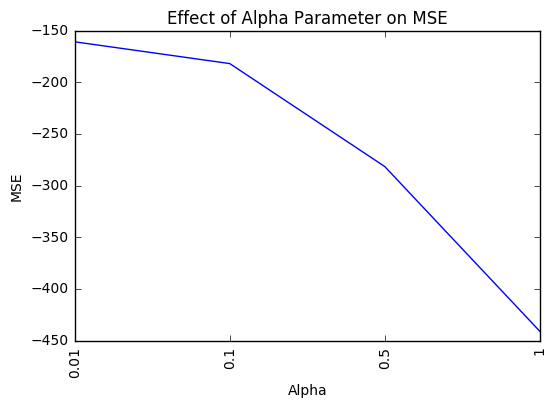

In [33]:
plt.plot(mse)
plt.xlabel('Alpha')
labels = [1e-2, 0.1, 0.5, 1]
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.ylabel('MSE')
plt.title('Effect of Alpha Parameter on MSE')
plt.show()